# Étude des *features* par classe (via échantillon) / jeu de données Escale

## Imports

In [18]:
%matplotlib inline

In [3]:
from pathlib import Path

In [4]:
import pandas as pd

In [5]:
# from joblib import Memory, Parallel, delayed

In [6]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [22]:
plt.style.use("seaborn-notebook")

In [8]:
from geo3dfeatures.io import las as read_las
from geo3dfeatures.extract import process_eigenvalues, process_full
from geo3dfeatures.extract import compute_tree, request_tree, extract

## Données

In [10]:
PREFIX_NAME = "escale"
SCENE_FILE = PREFIX_NAME + ".las"
ROUTE_FILE = PREFIX_NAME + "_route.las"
VEGETATION_FILE = PREFIX_NAME + "_vegetation.las"
FALAISE_FILE = PREFIX_NAME + "_falaise.las"

In [11]:
DATADIR = Path("/home/dag/data/geolithe-univers/workspace/input")

In [12]:
LABELS = {"route": 0,
          "falaise": 1,
          "vegetation": 2}

In [13]:
# Labels des coordonnées
COORDS = list("xyz")
# Labels du channel RGB (couleurs)
COULEURS = list("rgb")

In [13]:
rawdata = read_las(DATADIR / SCENE_FILE)
rawdata = pd.DataFrame(rawdata, columns=list("xyzrgb"))

In [14]:
print("dimension: ", rawdata.shape)
rawdata.head()

dimension:  (1069569, 6)


,x,y,z,r,g,b
0,19.190002,-86.450012,418.510002,214.0,210.0,200.0
1,19.179993,-86.500000,418.510002,214.0,210.0,199.0
2,19.169983,-86.479980,418.510002,217.0,214.0,208.0
3,19.169983,-86.500000,418.489998,216.0,213.0,206.0
4,19.250000,-86.450012,418.440002,179.0,172.0,167.0


## Index spatial

In [11]:
# Taille max des feuilles
LEAF_SIZE = 1_000

In [12]:
tree = compute_tree(rawdata[COORDS].values, leaf_size=LEAF_SIZE)

In [13]:
# on teste la requête d'un point prix au hasard
random_point = rawdata[COORDS].sample()
random_point

,x,y,z
117176,13.809998,-94.099976,415.300003


On récupère la distance et les index des K plus proches voisins (ici K=20)

In [14]:
distance, neighbors_index = request_tree(random_point.values, tree, 20)
distance, neighbors_index = distance.squeeze(), neighbors_index.squeeze()
print("distance: ", distance)
print("index: ", neighbors_index)

distance:  [0.         0.03163196 0.04690118 0.0538235  0.05920309 0.06707931
 0.07545484 0.09113635 0.09168442 0.10051111 0.10767244 0.10865246
 0.11178159 0.11871801 0.12206854 0.13493961 0.14597011 0.14629623
 0.15266149 0.15361005 0.15395666]
index:  [117176 117194 117174 117177 117182 117193 117175 117179 117192 117282
  83310 117183 117283  83445 117178 117181 117287 117185 117281 117195
 117189]


In [15]:
# Les 20 points proches (+ 1, celui au centre de la sphère)
rawdata.loc[neighbors_index]

,x,y,z,r,g,b
117176,13.809998,-94.099976,415.300003,149.0,142.0,116.0
117194,13.820007,-94.099976,415.269997,125.0,114.0,102.0
117174,13.840027,-94.070007,415.320000,50.0,36.0,22.0
117177,13.770020,-94.080017,415.269997,95.0,86.0,76.0
117182,13.820007,-94.150024,415.330002,64.0,50.0,39.0
117193,13.830017,-94.049988,415.260002,87.0,77.0,65.0
117175,13.789978,-94.030029,415.279999,159.0,154.0,129.0
117179,13.739990,-94.150024,415.330002,140.0,129.0,125.0
117192,13.890015,-94.140015,415.279999,63.0,49.0,36.0
117282,13.729980,-94.039978,415.290001,163.0,157.0,113.0


In [16]:
# Distance (en m)
pd.Series(distance).describe()

count    21.000000
mean      0.098750
std       0.043725
min       0.000000
25%       0.067079
50%       0.107672
75%       0.134940
max       0.153957
dtype: float64

## Features sur les échantillons

On souhaite calculer toutes les *features* sur l'ensemble des échantillons en prenant en considération la totalité de la scène.

On veut aussi calculer ces *features* pour différentes valeurs de "proches voisins".

### Lecture des données

In [17]:
vegetation = pd.DataFrame(read_las(DATADIR / VEGETATION_FILE), columns=COORDS + COULEURS)
falaise = pd.DataFrame(read_las(DATADIR / FALAISE_FILE), columns=COORDS + COULEURS)
route = pd.DataFrame(read_las(DATADIR / ROUTE_FILE), columns=COORDS + COULEURS)

In [19]:
print("dimension: ", vegetation.shape)
vegetation.head()

dimension:  (53978, 6)


,x,y,z,r,g,b
0,11.26001,-93.719969,417.280000,180.0,164.0,127.0
1,11.23999,-93.729979,417.290002,185.0,171.0,134.0
2,11.25000,-93.830015,417.280000,206.0,196.0,160.0
3,11.26001,-93.770018,417.260003,188.0,175.0,135.0
4,11.48999,-92.190001,416.860001,202.0,199.0,150.0


In [20]:
print("dimension: ", falaise.shape)
falaise.head()

dimension:  (35285, 6)


,x,y,z,r,g,b
0,1.349976,-99.999998,399.739998,167.0,169.0,161.0
1,1.429993,-100.020018,399.699997,186.0,188.0,183.0
2,1.390015,-100.010008,399.699997,190.0,191.0,186.0
3,1.419983,-99.950011,399.639999,176.0,178.0,173.0
4,1.419983,-99.999998,399.680000,171.0,174.0,166.0


In [21]:
print("dimension: ", route.shape)
route.head()

dimension:  (16833, 6)


,x,y,z,r,g,b
0,-7.030029,-102.659971,387.669998,188.0,191.0,194.0
1,-7.049988,-102.590025,387.660004,182.0,186.0,189.0
2,-7.030029,-102.590025,387.650002,192.0,194.0,195.0
3,-7.039978,-102.659971,387.669998,184.0,188.0,191.0
4,-7.059998,-102.690001,387.660004,195.0,199.0,202.0


### Ordre des grandeurs des distances en fonction du nombre de voisins

Prenons par exemple ce range de nombres de voisons

In [14]:
VOISINS_NUM = [10, 20, 30, 50, 100, 200, 500, 1000, 1500, 2000]

On peut regarder, en moyenne sur un échantillon 20 points par ex., la distance max i.e. le rayon de la sphère pour chaque voisinage.

In [23]:
veg_sample = vegetation[COORDS].sample(20).values
gen = (request_tree(veg_sample, tree, num) for num in VOISINS_NUM)
d = [{"mean": d.mean(axis=1)[0], "max": d.max(axis=1)[0]} for d, _ in gen]
pd.DataFrame(d, index=VOISINS_NUM)

,max,mean
10,0.125670,0.100475
20,0.173239,0.126465
30,0.210946,0.148516
50,0.251808,0.182052
100,0.323884,0.235632
200,0.444079,0.309636
500,0.647769,0.460494
1000,0.860227,0.608052
1500,1.023842,0.720424
2000,1.159408,0.813707


In [24]:
route_sample = route[COORDS].sample(20).values
gen = (request_tree(route_sample, tree, num) for num in VOISINS_NUM)
d = [{"mean": d.mean(axis=1)[0], "max": d.max(axis=1)[0]} for d, _ in gen]
pd.DataFrame(d, index=VOISINS_NUM)

,max,mean
10,0.114481,0.077375
20,0.146978,0.103797
30,0.182755,0.125075
50,0.228254,0.157438
100,0.316864,0.216314
200,0.452333,0.302354
500,0.690568,0.468280
1000,0.971309,0.654857
1500,1.184425,0.796914
2000,1.364726,0.916771


In [25]:
falaise_sample = falaise[COORDS].sample(20).values
gen = (request_tree(falaise_sample, tree, num) for num in VOISINS_NUM)
d = [{"mean": d.mean(axis=1)[0], "max": d.max(axis=1)[0]} for d, _ in gen]
pd.DataFrame(d, index=VOISINS_NUM)

,max,mean
10,0.099456,0.069662
20,0.140013,0.095777
30,0.163093,0.114007
50,0.206150,0.141880
100,0.284786,0.193438
200,0.408529,0.268778
500,0.661018,0.434103
1000,0.948186,0.623682
1500,1.159693,0.767728
2000,1.332551,0.887755


Pour les 1000 proches voisins, en max on est pas loin du mètre.

### Études des features par label (hdf5)

On a extrait des features dans autant de voisinage et autant de classe dans des fichiers CSV. Puis rassembler l'ensemble des valeurs dans des fichiers hdf5.

On souhaite comparer des profils de certaines features en fonction de la distance (resp. du nombre de voisins) par type de classe : **falaise**, **route** et **vegetation**

In [15]:
KEYS = {i: "/num_{:04d}".format(i) for i in VOISINS_NUM}
KEYS

{10: '/num_0010',
 20: '/num_0020',
 30: '/num_0030',
 50: '/num_0050',
 100: '/num_0100',
 200: '/num_0200',
 500: '/num_0500',
 1000: '/num_1000',
 1500: '/num_1500',
 2000: '/num_2000'}

In [16]:
vegetation_store = pd.HDFStore("escale-vegetation-features.h5", "r")
falaise_store = pd.HDFStore("escale-falaise-features.h5", "r")
route_store = pd.HDFStore("escale-route-features.h5", "r")

In [19]:
def mean_features(store, feature_name):
    result = pd.Series({num: store[key][feature_name].mean() for num, key in KEYS.items()})
    result.name = feature_name
    return result

In [24]:
mean_features(vegetation_store, "alpha")

10      0.269062
20      0.202032
30      0.177485
50      0.157332
100     0.143495
200     0.143083
500     0.152259
1000    0.159624
1500    0.161817
2000    0.161938
Name: alpha, dtype: float64

#### Distance : radius & radius 2D

In [25]:
radius = pd.DataFrame({"vegetation": mean_features(vegetation_store, "radius"),
                       "falaise": mean_features(falaise_store, "radius"),
                       "route": mean_features(route_store, "radius")})

In [26]:
radius

,vegetation,falaise,route
10,0.133246,0.101486,0.100924
20,0.180289,0.135939,0.140092
30,0.215895,0.163207,0.170508
50,0.271816,0.206665,0.217429
100,0.372865,0.287484,0.305714
200,0.509733,0.402815,0.430918
500,0.774036,0.632953,0.679818
1000,1.059306,0.892910,0.960961
1500,1.272128,1.092592,1.176933
2000,1.448044,1.261158,1.359032


Text(0, 0.5, 'rayon moy. (m)')

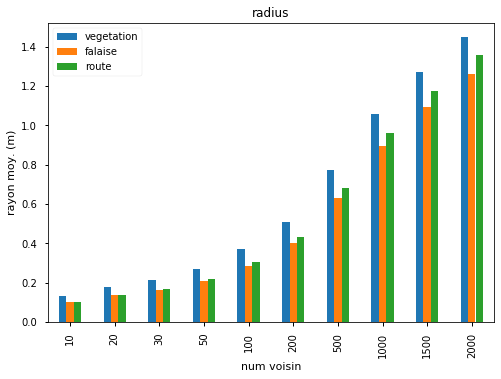

In [27]:
radius.plot(kind="bar", title="radius")
plt.xlabel("num voisin")
plt.ylabel("rayon moy. (m)")

In [28]:
radius_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, "radius_2D"),
                         "falaise": mean_features(falaise_store, "radius_2D"),
                         "route": mean_features(route_store, "radius_2D")})

Text(0, 0.5, 'rayon 2D moy. (m)')

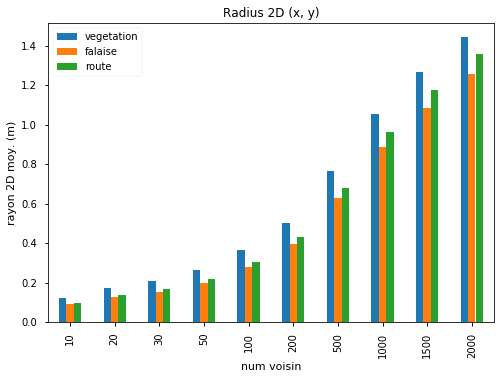

In [29]:
radius_2d.plot(kind="bar", title="Radius 2D (x, y)")
plt.xlabel("num voisin")
plt.ylabel("rayon 2D moy. (m)")

#### Densité - 2D et 3D

In [30]:
key = "density_2D"
density_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "route": mean_features(route_store, key)})

Text(0, 0.5, 'density 2D moy.')

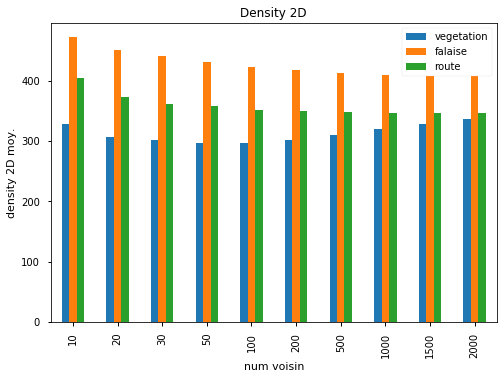

In [31]:
density_2d.plot(kind="bar", title="Density 2D")
plt.xlabel("num voisin")
plt.ylabel("density 2D moy.")

In [33]:
key = "density"
density_3d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "route": mean_features(route_store, key)})

Text(0, 0.5, 'density 3D moy.')

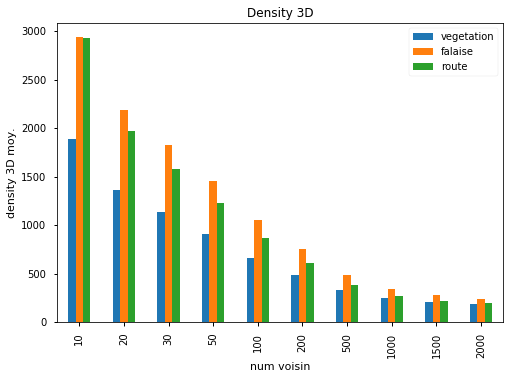

In [34]:
density_3d.plot(kind="bar", title="Density 3D")
plt.xlabel("num voisin")
plt.ylabel("density 3D moy.")

#### Autres features 2D : eigen values sum & ratio

In [27]:
key = "eigenvalue_ratio_2D"
eigenratio_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "route": mean_features(route_store, key)})

Text(0, 0.5, 'Ratio e2/e1 moy.')

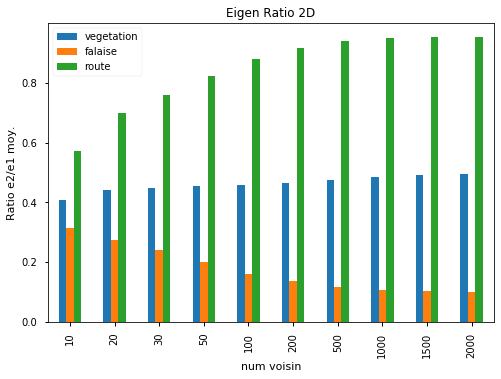

In [28]:
eigenratio_2d.plot(kind="bar", title="Eigen Ratio 2D")
plt.xlabel("num voisin")
plt.ylabel("Ratio e2/e1 moy.")

In [25]:
key = "eigenvalue_sum_2D"
eigensum_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "route": mean_features(route_store, key)})

Text(0, 0.5, 'Eigen values sum moy.')

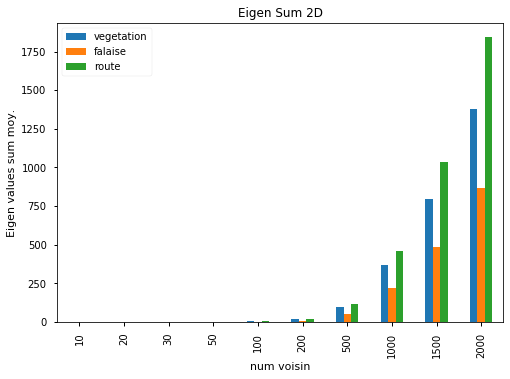

In [26]:
eigensum_2d.plot(kind="bar", title="Eigen Sum 2D")
plt.xlabel("num voisin")
plt.ylabel("Eigen values sum moy.")

#### alpha & beta

In [35]:
alpha = pd.DataFrame({"vegetation": mean_features(vegetation_store, "alpha"),
                     "falaise": mean_features(falaise_store, "alpha"),
                     "route": mean_features(route_store, "alpha")})

In [36]:
alpha

,vegetation,falaise,route
10,0.269062,0.242543,0.269137
20,0.202032,0.160800,0.177204
30,0.177485,0.126119,0.136457
50,0.157332,0.095108,0.097340
100,0.143495,0.066303,0.063429
200,0.143083,0.051095,0.042831
500,0.152259,0.041621,0.030152
1000,0.159624,0.036520,0.025530
1500,0.161817,0.035482,0.024478
2000,0.161938,0.035493,0.024201


Text(0, 0.5, 'aplha')

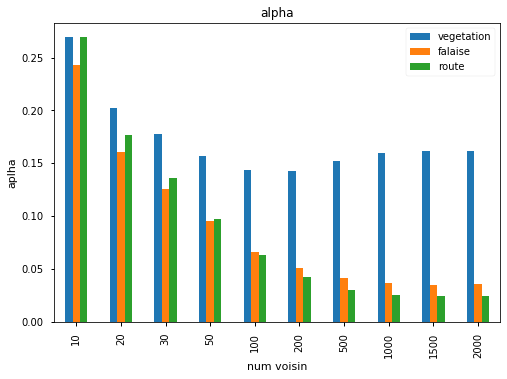

In [37]:
alpha.plot(kind='bar', title="alpha")
plt.xlabel("num voisin")
plt.ylabel("aplha")

In [38]:
beta = pd.DataFrame({"vegetation": mean_features(vegetation_store, "beta"),
                     "falaise": mean_features(falaise_store, "beta"),
                     "route": mean_features(route_store, "beta")})

In [39]:
beta

,vegetation,falaise,route
10,0.464119,0.476589,0.585939
20,0.524447,0.600756,0.723477
30,0.557751,0.676723,0.789235
50,0.590027,0.758787,0.853260
100,0.616300,0.842960,0.908524
200,0.615268,0.894009,0.941308
500,0.585597,0.927558,0.962378
1000,0.558049,0.940768,0.970214
1500,0.543306,0.944475,0.972154
2000,0.535648,0.945788,0.972347


Text(0, 0.5, 'beta')

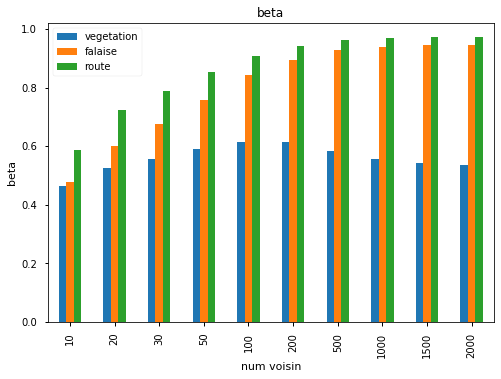

In [40]:
# plus beta est grand -> dimension 2D
beta.plot(kind="bar", title="beta")
plt.xlabel("num voisin")
plt.ylabel("beta")

Text(0.5, 0, 'num voisin')

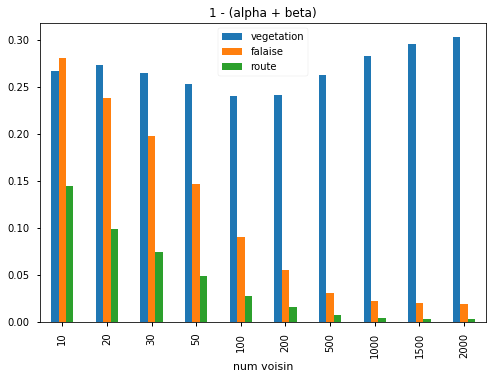

In [44]:
# ici, plus la valeur est grande plus la dimension 3D est prépondérante
(1 - (alpha + beta)).plot(kind="bar", title='1 - (alpha + beta)')
plt.xlabel("num voisin")

On veut pouvoir tracer l'évolution des ces trois valeurs en fonction de la distance (resp. nombre de voisins) pour chaque type d'éléments

In [55]:
triangle_vegetation = pd.DataFrame({"alpha": mean_features(vegetation_store, "alpha"),
                     "beta": mean_features(vegetation_store, "beta")})

triangle_vegetation["gamma"] = triangle_vegetation.eval("1 - alpha - beta")

In [56]:
triangle_vegetation

,alpha,beta,gamma
10,0.269062,0.464119,0.266819
20,0.202032,0.524447,0.273521
30,0.177485,0.557751,0.264764
50,0.157332,0.590027,0.252641
100,0.143495,0.616300,0.240205
200,0.143083,0.615268,0.241649
500,0.152259,0.585597,0.262144
1000,0.159624,0.558049,0.282327
1500,0.161817,0.543306,0.294877
2000,0.161938,0.535648,0.302414


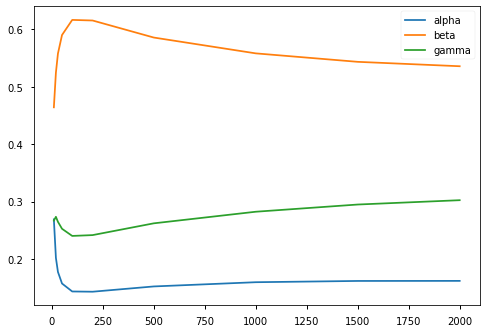

In [57]:
triangle_vegetation.plot()

In [60]:
triangle_falaise = pd.DataFrame({"alpha": mean_features(falaise_store, "alpha"),
                     "beta": mean_features(falaise_store, "beta")})

triangle_falaise["gamma"] = triangle_falaise.eval("1 - alpha - beta")

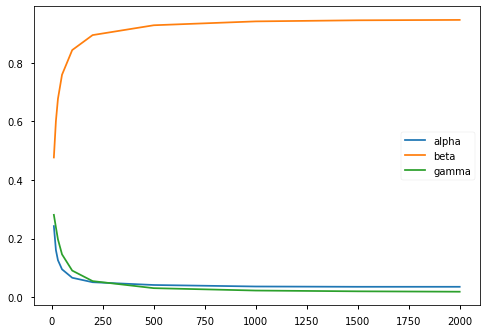

In [61]:
triangle_falaise.plot()

In [63]:
triangle_route = pd.DataFrame({"alpha": mean_features(route_store, "alpha"),
                     "beta": mean_features(route_store, "beta")})

triangle_route["gamma"] = triangle_route.eval("1 - alpha - beta")

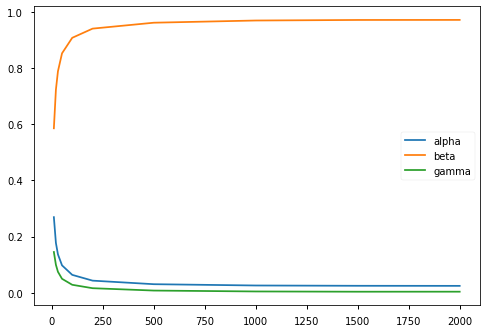

In [64]:
triangle_route.plot()

#### Notion de verticalité

In [42]:
key = "verticality"
verticality = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "route": mean_features(route_store, key)})

Text(0, 0.5, 'verticality')

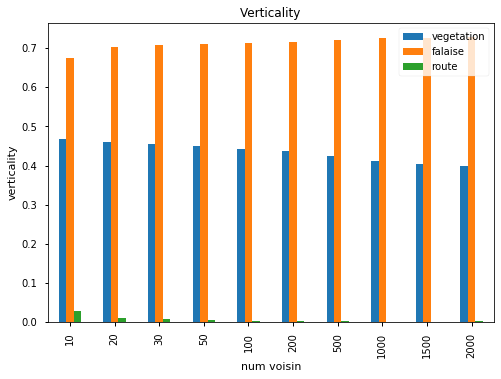

In [43]:
verticality.plot(kind="bar", title="Verticality")
plt.xlabel("num voisin")
plt.ylabel("verticality")

#### Linerarity, planarity & scattering

In [66]:
key = "linearity"
linearity = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, '(e1 - e2)/e1 moy.')

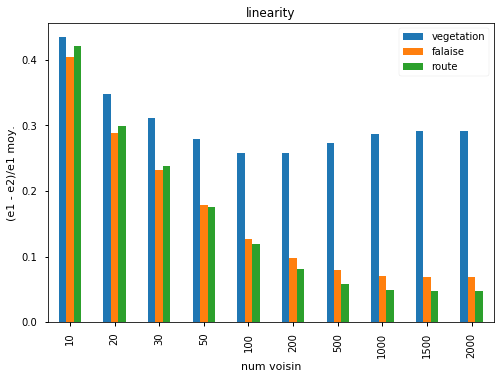

In [67]:
linearity.plot(kind="bar", title="linearity")
plt.xlabel("num voisin")
plt.ylabel("(e1 - e2)/e1 moy.")

In [68]:
key = "planarity"
planarity = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, '(e2 - e3)/e1 moy.')

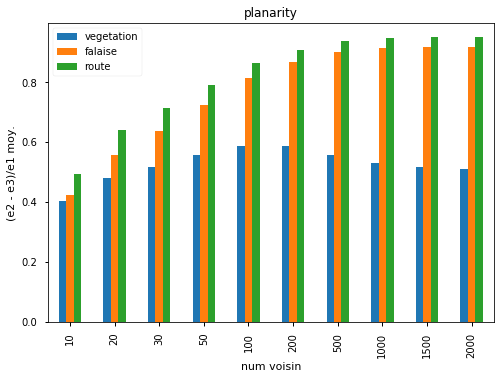

In [69]:
planarity.plot(kind="bar", title="planarity")
plt.xlabel("num voisin")
plt.ylabel("(e2 - e3)/e1 moy.")

In [70]:
key = "scattering"
scattering = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, 'e3 / e1 moy.')

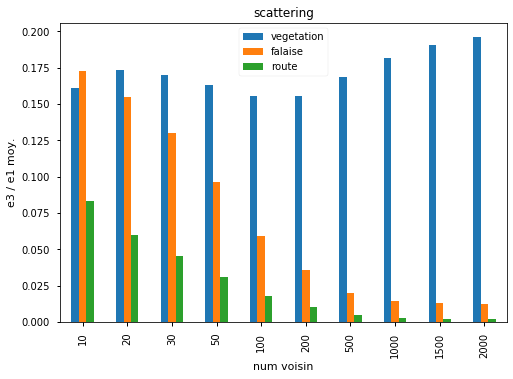

In [71]:
scattering.plot(kind="bar", title="scattering")
plt.xlabel("num voisin")
plt.ylabel("e3 / e1 moy.")

#### Curvature Change

In [20]:
key = "curvature_change"
curvature = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, 'e3 / (e1+e2+e3) moy.')

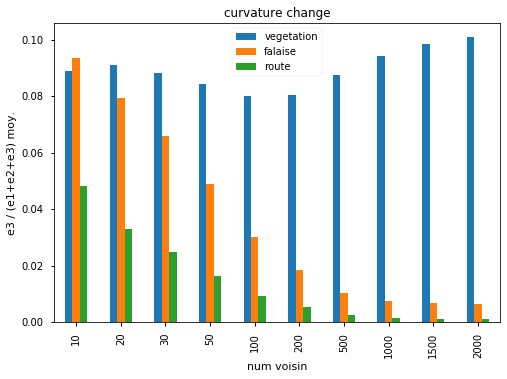

In [23]:
curvature.plot(kind="bar", title="curvature change")
plt.xlabel("num voisin")
plt.ylabel("e3 / (e1+e2+e3) moy.")

#### Omnivariance

In [72]:
key = "omnivariance"
omnivariance = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, 'sqrt(e1*e2*e3), 3) moy.')

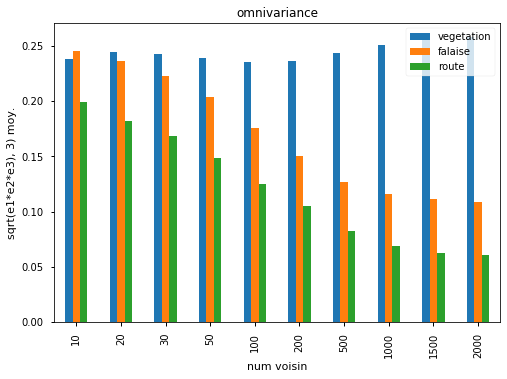

In [73]:
omnivariance.plot(kind="bar", title="omnivariance")
plt.xlabel("num voisin")
plt.ylabel("sqrt(e1*e2*e3), 3) moy.")

#### Anisotropy

In [74]:
key = "anisotropy"
anisotropy = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, '(e1 - e3)/e1 moy.')

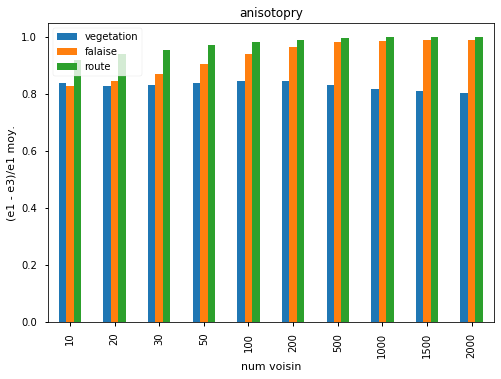

In [75]:
anisotropy.plot(kind="bar", title="anisotopry")
plt.xlabel("num voisin")
plt.ylabel("(e1 - e3)/e1 moy.")

#### Eigentropy

In [77]:
key = "eigenentropy"
eigentropy = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, 'minus sum e_i * ln e_i')

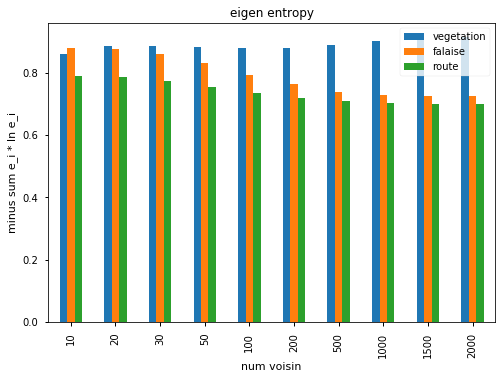

In [81]:
eigentropy.plot(kind="bar", title="eigen entropy")
plt.xlabel("num voisin")
plt.ylabel("minus sum e_i * ln e_i")

#### Eigenvalues Sum

In [79]:
key = "eigenvalue_sum"
eigensum = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, 'sum lambda_i')

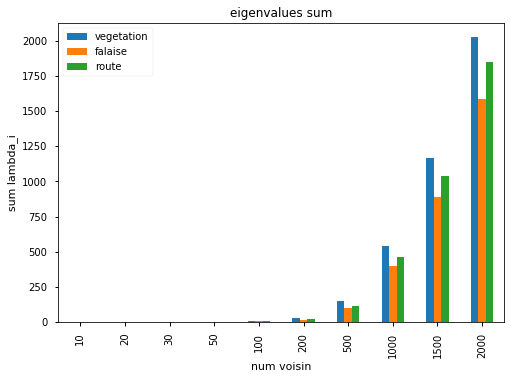

In [80]:
eigensum.plot(kind="bar", title="eigenvalues sum")
plt.xlabel("num voisin")
plt.ylabel("sum lambda_i")

#### z-axis features & accumulation features (bin)

In [33]:
key = "z_range"
z_range = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, 'z-range moy. (m)')

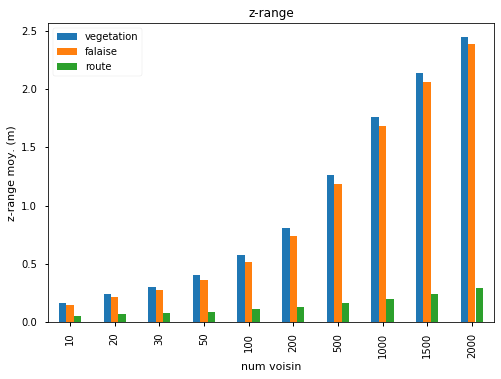

In [34]:
z_range.plot(kind="bar", title="z-range")
plt.xlabel("num voisin")
plt.ylabel("z-range moy. (m)")

In [31]:
key = "std_dev"
z_sigma = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})

Text(0, 0.5, 'std dev along z moy. (m)')

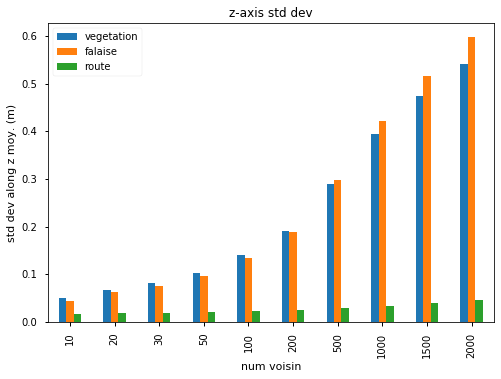

In [35]:
z_sigma.plot(kind="bar", title="z-axis std dev")
plt.xlabel("num voisin")
plt.ylabel("std dev along z moy. (m)")

In [41]:
key = "bin_z_range"
z_bin_range = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})
print("**Attention** bin pas tous même taille en fonction du nombre de voisins...")

**Attention** bin pas tous même taille en fonction du nombre de voisins...


Text(0, 0.5, 'z range moy. (m)')

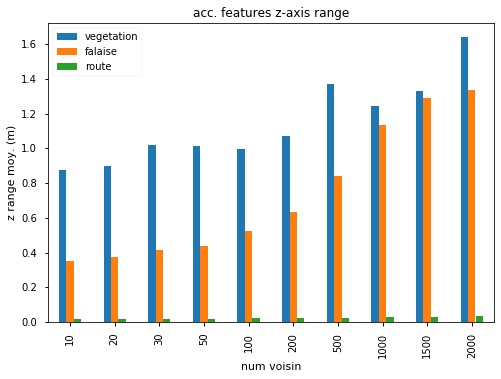

In [43]:
z_bin_range.plot(kind="bar", title="acc. features z-axis range")
plt.xlabel("num voisin")
plt.ylabel("z range moy. (m)")

In [44]:
key = "bin_z_std"
z_bin_sigma = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})
print("**Attention** bin pas tous même taille en fonction du nombre de voisins...")

**Attention** bin pas tous même taille en fonction du nombre de voisins...


Text(0, 0.5, 'std dev along z moy. (m)')

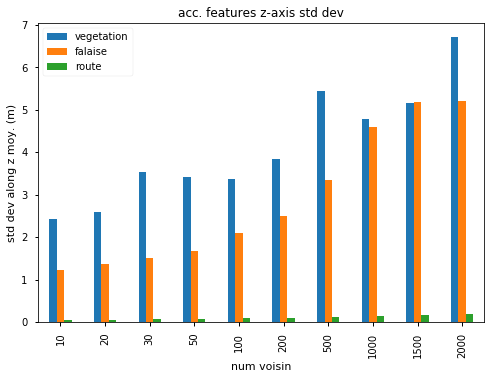

In [45]:
z_bin_sigma.plot(kind="bar", title="acc. features z-axis std dev")
plt.xlabel("num voisin")
plt.ylabel("std dev along z moy. (m)")

In [46]:
key = "bin_density"
z_bin_density = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "route": mean_features(route_store, key)})
print("**Attention** bin pas tous même taille en fonction du nombre de voisins...")

**Attention** bin pas tous même taille en fonction du nombre de voisins...


Text(0, 0.5, 'density bin')

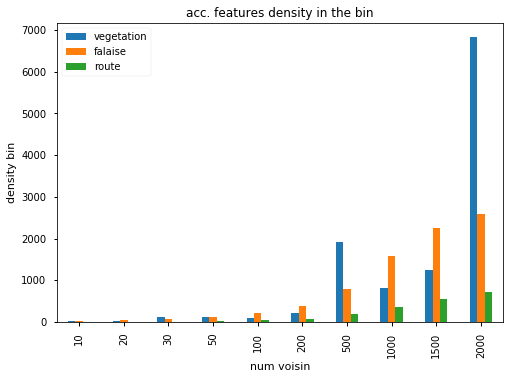

In [48]:
z_bin_density.plot(kind="bar", title="acc. features density in the bin")
plt.xlabel("num voisin")
plt.ylabel("density bin")

### Corrélation de features pour un nombre de voisins donné

* On va concaténer selon axis=0 les données issues des différents échantillons (végétation, falaise, route) pour un nombre de voisin donné
* On va calculer  une matrice de corrélation entre différente *features*

In [55]:
VOISIN_30 = "/num_0030"    # rayon sphère environ 20cm
VOISIN_1500 = "/num_1500"  # rayon sphère environ 1m

In [49]:
FEATURE_NAMES =  ['alpha',
 'beta',
 'radius',
 'z_range',
 'std_dev',
 'density',
 'verticality',
 'curvature_change',
 'linearity',
 'planarity',
 'scattering',
 'omnivariance',
 'anisotropy',
 'eigenentropy',
 'eigenvalue_sum',
 'radius_2D',
 'density_2D',
 'eigenvalue_sum_2D',
 'eigenvalue_ratio_2D']

In [56]:
def concat_features(voisin_num):
    return pd.concat([vegetation_store[voisin_num],
                      falaise_store[voisin_num],
                      route_store[voisin_num]], axis=0, ignore_index=True)

In [57]:
features_30 = concat_features(VOISIN_30)

In [58]:
features_1500 = concat_features(VOISIN_1500)

In [59]:
rho_30 = features_30[FEATURE_NAMES].corr()

In [60]:
rho_1500 = features_1500[FEATURE_NAMES].corr()

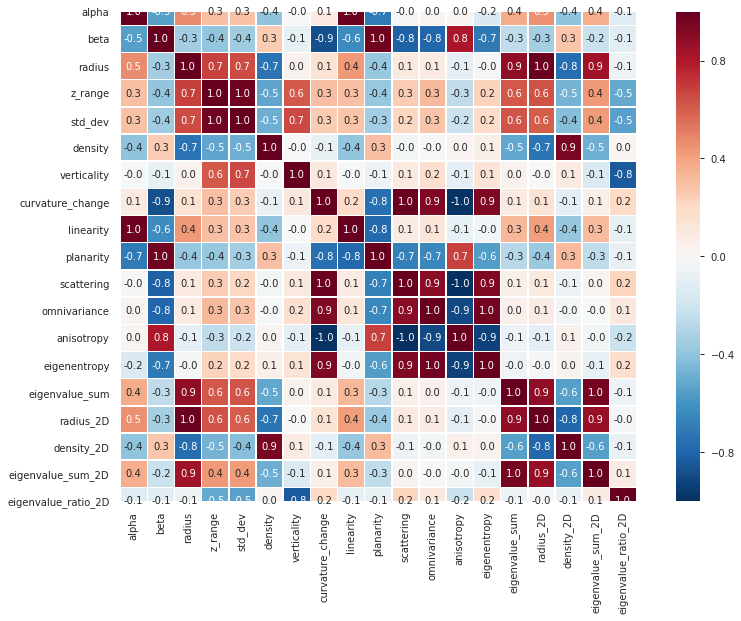

In [110]:
with sns.axes_style("white", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(14, 9))
    sns.heatmap(rho_30, square=True, cmap='RdBu_r', center=0., linewidths=.5, annot=True, fmt=".1f", ax=ax)

In [111]:
# on peut ré-ordonner le nom des labels

In [61]:
b = rho_30.beta
cols = b.sort_values(ascending=False).index
cols

Index(['beta', 'planarity', 'anisotropy', 'density_2D', 'density',
       'verticality', 'eigenvalue_ratio_2D', 'eigenvalue_sum_2D',
       'eigenvalue_sum', 'radius_2D', 'radius', 'std_dev', 'z_range', 'alpha',
       'linearity', 'eigenentropy', 'omnivariance', 'scattering',
       'curvature_change'],
      dtype='object')

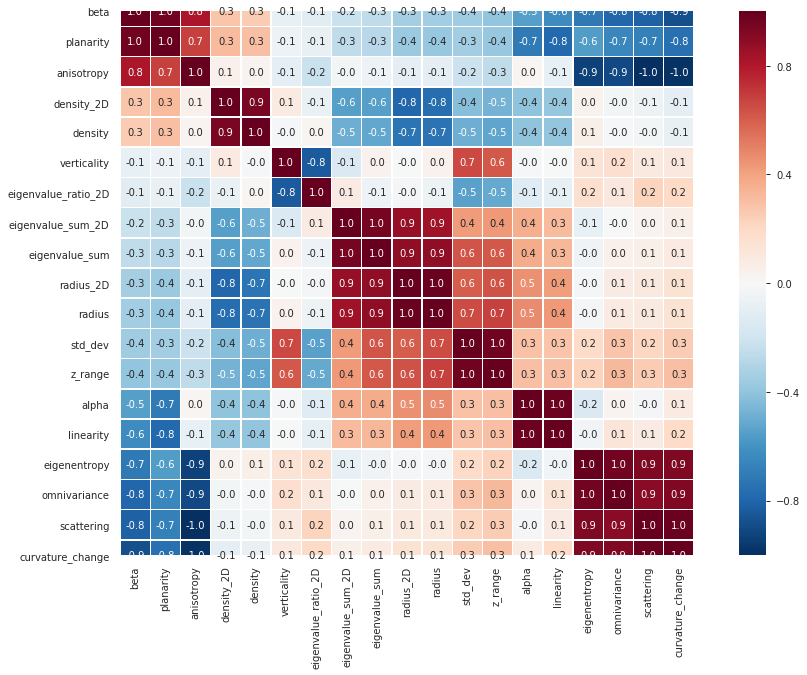

In [62]:
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(rho_30.loc[cols, cols], square=True, cmap='RdBu_r',
                center=0., linewidths=.5, annot=True, fmt=".1f", ax=ax)

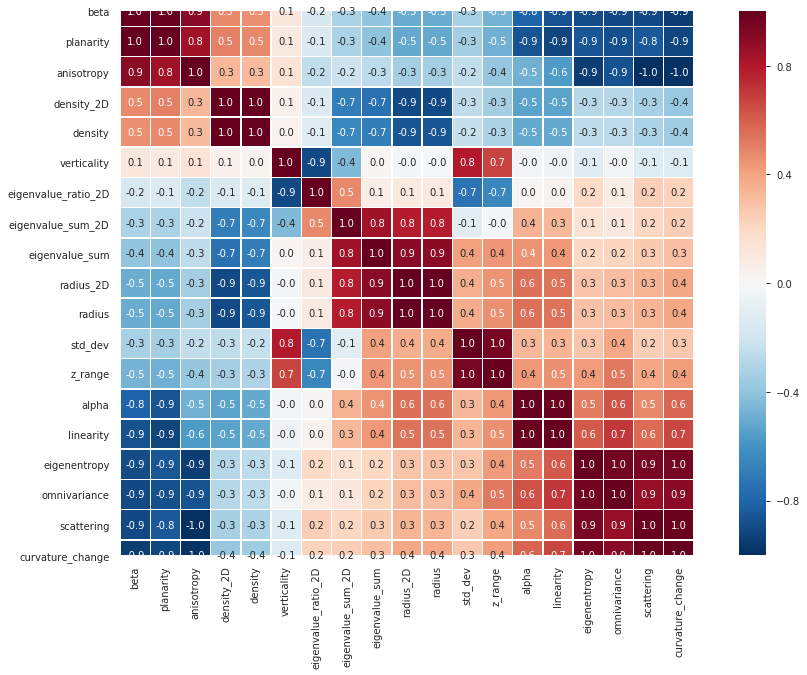

In [63]:
# Même matrice mais avec les features calculées pour les 1,500 voisins
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(rho_1500.loc[cols, cols], square=True, cmap='RdBu_r',
                center=0., linewidths=.5, annot=True, fmt=".1f", ax=ax)

### Tentative d'extraction de features pour un ensemble de voisinage (échoué)

In [101]:
def rename_fields(features, suffix):
    return [name + "_" + str(suffix) for name in features._fields]

In [122]:
def point_iterator(sample, full_scene_tree, neighbors):
    """
    neighbors : can be a int or a list of int
    """
    results = []
    if isinstance(neighbors, int):
        neighbors = [neighbors]
    for idx, record in sample.iterrows():
        point = record[list("xyz")].values
        for n in neighbors:
            distance, index = request_tree(point, full_scene_tree, nb_neighbors=n)
            results.append((idx, n, full_scene_tree.data[index], distance))
        yield results
        results = []
    return results

In [124]:
it = point_iterator(vegetation.sample(5), tree, [10,20])

In [128]:
def gen_featurize_me(iterator):
    current_idx = None
    group = []
    for idx, num, points, distance in iterator:
        features, _ = process_full(points, distance, list("czs"), None)
        names = rename_fields(features, num)
        results = list(zip(names, features))[3:-3] # je ne veux pas les extra features ou z-acc features
        if idx == current_idx or current_idx is None:
            group += results
            current_idx = idx
            continue
        else:
            yield [("x", features.x), ("y", features.y), ("z", features.z)] + group
            group = results
            current_idx = idx
    yield [("x", features.x), ("y", features.y), ("z", features.z)] + group    

In [119]:
def featurize_me(iterator):
    current_idx = None
    results = []
    group = []
    for idx, num, points, distance in iterator:
        features, _ = process_full(points, distance, list("czs"), None)
        names = rename_fields(features, num)
        tmp = list(zip(names, features))[3:-3] # je ne veux pas les extra features ou z-acc features
        if idx == current_idx or current_idx is None:
            group += tmp
            current_idx = idx
            continue
        else:
            results.append([("x", features.x), ("y", features.y), ("z", features.z)] + group)
            group = tmp
            current_idx = idx
    results.append([("x", features.x), ("y", features.y), ("z", features.z)] + group)
    return results

In [ ]:
veg_it = featurize_me(point_iterator(vegetation, tree, VOISINS_NUM))

In [ ]:
vegetation_features = Parallel(n_jobs=6)(delayed(featurize_me)(dataset) for dataset in point_iterator(vegetation.sample(50), tree, VOISINS_NUM))

In [ ]:
extract(vegetation.values,
        tree,
        Path("vegeration-features-.csv"),
        extra_columns=tuple("rgb"),
        nb_neighbors=10,
        bin_size=0.10,
        nb_processes=5,
        chunksize=5000)

[15:13:52] extract.extract (INFO) - Computation begins!
[15:13:53] extract.extract (INFO) - Total number of points: 53978
100%|██████████| 11/11 [00:19<00:00,  1.22it/s]


In [ ]:
for nb_neighbors in VOISINS_NUM[1:]:
    print(nb_neighbors)
    extract(vegetation.values,
        tree,
        Path("vegetation-features-{:04d}.csv".format(nb_neighbors)),
        extra_columns=tuple("rgb"),
        nb_neighbors=nb_neighbors,
        bin_size=0.10,
        nb_processes=4,
        chunksize=5000)
    

[15:17:45] extract.extract (INFO) - Computation begins!


20


[15:17:46] extract.extract (INFO) - Total number of points: 53978
100%|██████████| 11/11 [00:19<00:00,  1.13it/s]

Je ne sais pas pourquoi, à la sortie de `extract` le **kernel du notebook plante...**